#-------------------------------------------------------------------------------------------------
### NOTE: All code and documentation are presented in English due to a mandatory language requirement.
### NOTE: Todo el código y la documentación se presentan en inglés debido a una obligación de uso del idioma.
#-------------------------------------------------------------------------------------------------

### Data Exploration and Cleaning

This dataset contains information about Indian cars, including technical specifications, usage, and pricing.

We will perform the following steps to prepare the data for analysis and modeling:
1. Initial Data Inspection

   - Review column names

   - Preview the first few rows

   - Examine data types

   - Perform an initial exploratory analysis

   - Understand the distribution of key variables

2. Handling Missing Values

   - Identify columns with null values and assess their impact

   - Evaluate the feasibility of imputing or removing missing data

   - Where applicable, merge values from New_Price into Price for enhanced completeness

   - Clean and transform improperly formatted or mixed-type columns

3. Modify data types 
    - Transform data types 
    - Rename columns 


In [1]:
# Libraries to explore and visualize the data
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
from logger_setup import get_file_logger
logger = get_file_logger("data_cleaning_")

dataset_save_path = "datasets/vehicles/clean_car_df.csv"

# Load the data
logger.debug("Load dataset from datasets/vehicles/used_cars_data.csv")
cars_df_raw = pd.read_csv("datasets/vehicles/used_cars_data.csv")
logger.debug(f"Initial shape: {cars_df_raw.shape}")

2025-06-13 23:29:47,022 | DEBUG | data_cleaning_ | Load dataset from datasets/vehicles/used_cars_data.csv
2025-06-13 23:29:47,085 | DEBUG | data_cleaning_ | Initial shape: (7253, 14)


### Column names
```
S.No.                 | Index of the dataset
Name                  | Name of the vehicle
Location              | Location of the vehicle
Year                  | Manufacturing year
Kilometers_driven     | Mileage driven 
Fuel_Type             | Type of fuel
Transmission          | Type of transmission
Owner_Type            | Number of owner
Mileage               | Mileage in kmpl km/kg
Engine                | Type of engine in CC
Power                 | Brake HorsePower in bhp
Seats                 | Quantity of seats
New_Price             | New price in lakh / cr
Price                 | Actual price
```

In [2]:
cars_df_raw.head()
logger.debug("Show first rows from the dataset")

2025-06-13 23:29:47,090 | DEBUG | data_cleaning_ | Show first rows from the dataset


#### Schema information 

The dataset consists of 7,253 entries. Most features are stored as `object` data types, which usually represent categorical or text-based information. 

However, some of these columns actually contain numeric values combined with units (e.g., `Mileage`: "26.6 km/kg", `Engine`: "998 CC", `Power`: "58.16 bhp", `New_Price`: "8.61 Lakh"). This formatting makes them unsuitable for direct numerical analysis and requires cleaning and conversion.

Additionally, several columns have missing values, which will need to be handled as part of the data preprocessing workflow.

In [3]:
# Schema of the data
Object_columns = cars_df_raw.select_dtypes(include=['object']).count().count()
Numeric_columns = cars_df_raw.select_dtypes(include=['number']).count().count()
logger.debug("Object columns:", Object_columns)
logger.debug("Numeric columns (int64 + float64):", Numeric_columns)
cars_df_raw.info()
logger.debug("Show dataset schema")


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Victor\AppData\Local\Programs\Python\Python313\Lib\logging\__init__.py", line 1150, in emit
    msg = self.format(record)
  File "C:\Users\Victor\AppData\Local\Programs\Python\Python313\Lib\logging\__init__.py", line 998, in format
    return fmt.format(record)
           ~~~~~~~~~~^^^^^^^^
  File "C:\Users\Victor\AppData\Local\Programs\Python\Python313\Lib\logging\__init__.py", line 711, in format
    record.message = record.getMessage()
                     ~~~~~~~~~~~~~~~~~^^
  File "C:\Users\Victor\AppData\Local\Programs\Python\Python313\Lib\logging\__init__.py", line 400, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "a:\Desktop\TFM\venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253 entries, 0 to 7252
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   S.No.              7253 non-null   int64  
 1   Name               7253 non-null   object 
 2   Location           7253 non-null   object 
 3   Year               7253 non-null   int64  
 4   Kilometers_Driven  7253 non-null   int64  
 5   Fuel_Type          7253 non-null   object 
 6   Transmission       7253 non-null   object 
 7   Owner_Type         7253 non-null   object 
 8   Mileage            7251 non-null   object 
 9   Engine             7207 non-null   object 
 10  Power              7207 non-null   object 
 11  Seats              7200 non-null   float64
 12  New_Price          1006 non-null   object 
 13  Price              6019 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 793.4+ KB


#### Statistics summary of the numeric columns:

- Seats:<br> 
    - The minimum value is `0`, which likely indicates missing or null data incorrectly represented as zero.
- Kilometers_Driven:<br>
    -   There is a noticeable jump between the 75th percentile and the maximum value, suggesting the presence of potential outliers.
- Price:<br>
    -   Similarly, a significant increase between the 75th percentile and the maximum value may indicate outliers in pricing data.

In [4]:
# Detailed data
cars_df_raw.describe()
logger.debug("Show dataset's descriptive statistics")

2025-06-13 23:29:47,125 | DEBUG | data_cleaning_ | Show dataset's descriptive statistics


### Object-Type Column Analysis and Distribution Summary

##### Categorical Columns identified: 
The following columns were identified as categorical:

- Location
- Fuel_Type
- Transmission
- Owner_Type

Nominal (No inherent order):
- Location (eg., Mumbai)
- Fuel Type (eg., CNG, LPG, Petrol, Diesel, Electric)
- Transmission (eg., Manual, Automatic)

Ordinal (Logical order present):
- Owner Type (e.g., First, Second, Third...)

##### Misclassified Object Columns:

The following `object-type` columns are misformatted and contain values in the form "[numeric value] [unit]", leading to inconsistent data typing:

- Mileage

- Engine

- Power

- New_Price

These should be split into distinct numerical and unit components to restore data type integrity.

Inferred Data types:

- Discrete:

    - Engine (CC values)

- Continuous:

    - Mileage (e.g., kmpl or km/kg)

    - Power (e.g., bhp)

    - New_Price (e.g., in INR lakhs and crores)

### Distribution Insights

- **Location**: Reasonably balanced across cities.
- **Fuel_Type**: Heavily skewed toward **Diesel** and **Petrol**.
- **Transmission**: **Manual** dominates, roughly in a 2:1 ratio over **Automatic**.
- **Owner_Type**: Majority are **first-owner** vehicles.
- **Mileage**, **Engine**, and **Power**: Show **right-skewed** distributions, indicating a higher frequency of lower values.
- **New_Price**: Appears more evenly distributed, although with a low data volume.


2025-06-13 23:29:47,132 | DEBUG | data_cleaning_ | Plotting object data


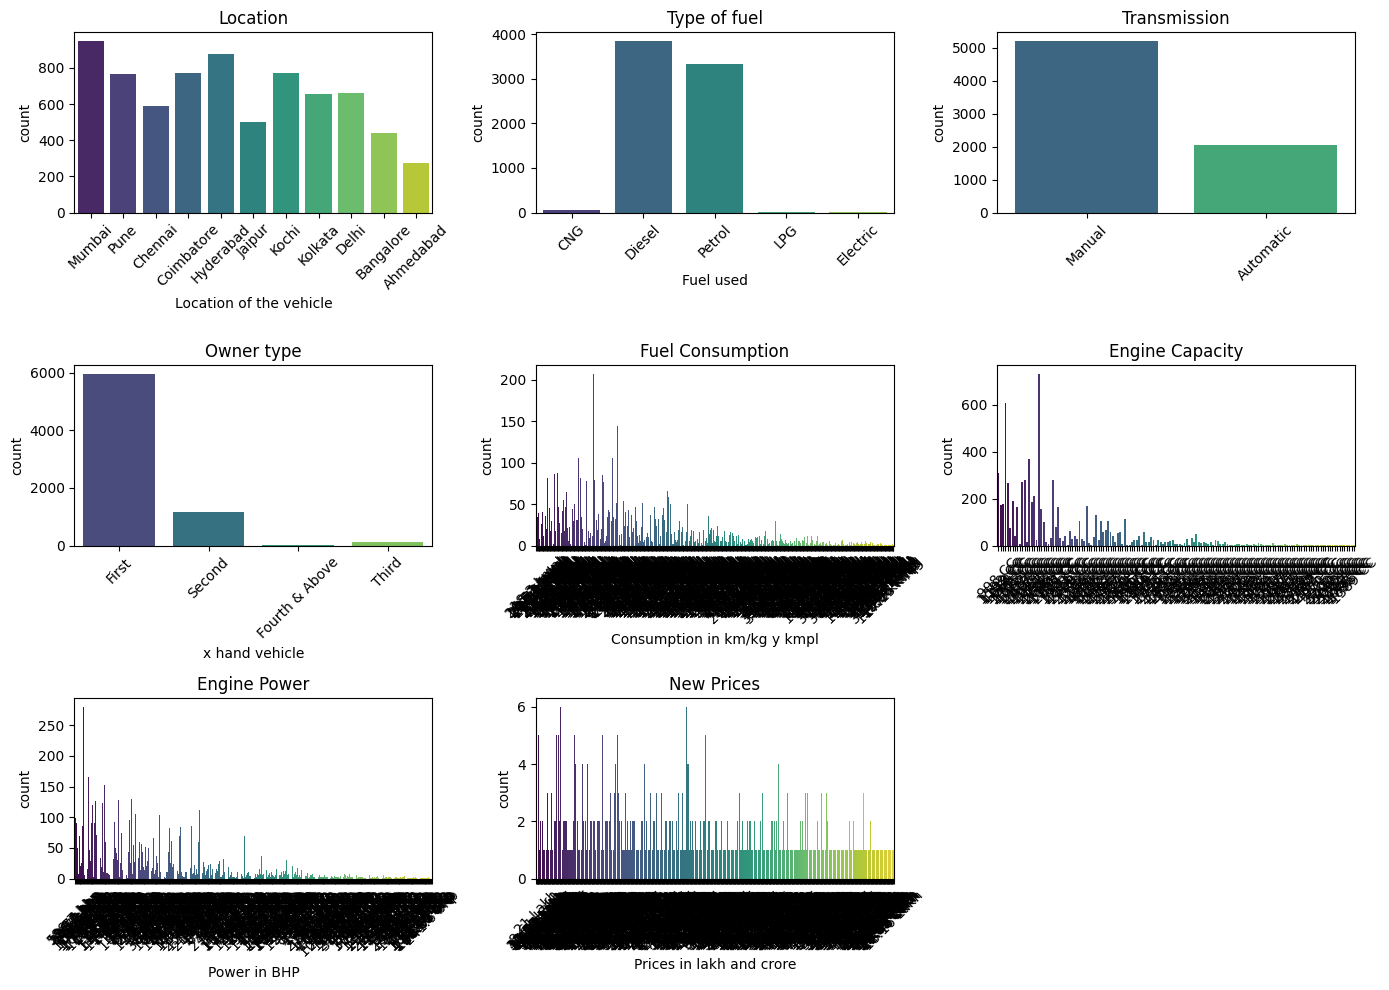

In [5]:
logger.debug("Plotting object data")
cat_columns = cars_df_raw.select_dtypes(include=['object']).drop('Name', axis=1)
#cat_columns = cars_df_raw[['Location',"Fuel_Type","Transmission","Owner_Type","Seats","Engine","Power","New_Price"]]
custom_labels = {
    'Location': {
        'title': 'Location',
        'xlabel': 'Location of the vehicle'
    },
    'Fuel_Type': {
        'title': 'Type of fuel',
        'xlabel': 'Fuel used'
    },
    'Transmission': {
        'title': 'Transmission',
        'xlabel': ''
    },
    'Owner_Type': {
        'title': 'Owner type',
        'xlabel': 'x hand vehicle'
    },
    'Mileage': {
        'title': 'Fuel Consumption',
        'xlabel': 'Consumption in km/kg y kmpl'
    },
    'Engine': {
        'title': 'Engine Capacity',
        'xlabel': ''
    },
    'Power': {
        'title': 'Engine Power',
        'xlabel': 'Power in BHP'
    },
    'New_Price': {
        'title': 'New Prices',
        'xlabel': 'Prices in lakh and crore'
    }
}

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(14, 10))
axes = axes.flatten()  # Flatten to make indexing easier

# Plot each categorical column
for i, col in enumerate(cat_columns.columns):
    sns.countplot(data=cat_columns, x=col, ax=axes[i],palette='viridis',hue=col, legend=False)
    axes[i].tick_params(axis='x',rotation=45)    
    axes[i].set_title(col)

    if col in custom_labels:
        axes[i].set_title(custom_labels[col]['title'])
        axes[i].set_xlabel(custom_labels[col]['xlabel'])
    else:
        axes[i].set_title(col)
        axes[i].set_xlabel(col)

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

#### Number Column Distribution Analysis

After plotting the numerical features, we classify them as follows:

**Categorical (Ordinal):**
- Seats 

**Numerical (Discrete):**
- Year

**Numerical (Continuous):**
- Kilometers_Driven
- Price (INR Lakh currency)

**Other Observations:**
- S.No. (Identifier column)

#### Distribution

- **Year**: The distribution is left-skewed, indicating that most vehicles are relatively recent models. This skew is expected and does not present an issue.
- **Seats**: Most entries reflect either 5 or 7 seats, which aligns with typical configurations in the Indian market. 
- **Kilometers Driven**: The distribution is highly right-skewed. With a 75th percentile at `~73,000` km and a maximum around `650,000` km, extreme values suggest the presence of outliers.
- **Price**: Also right-skewed. The 75th percentile is `₹9.95 Lakh`, while the maximum reaches `₹160 Lakh`, further indicating potential outliers.
- **S.No.**: This is simply an indexing column and holds no analytical value.


2025-06-13 23:29:53,256 | DEBUG | data_cleaning_ | Plotting numeric data


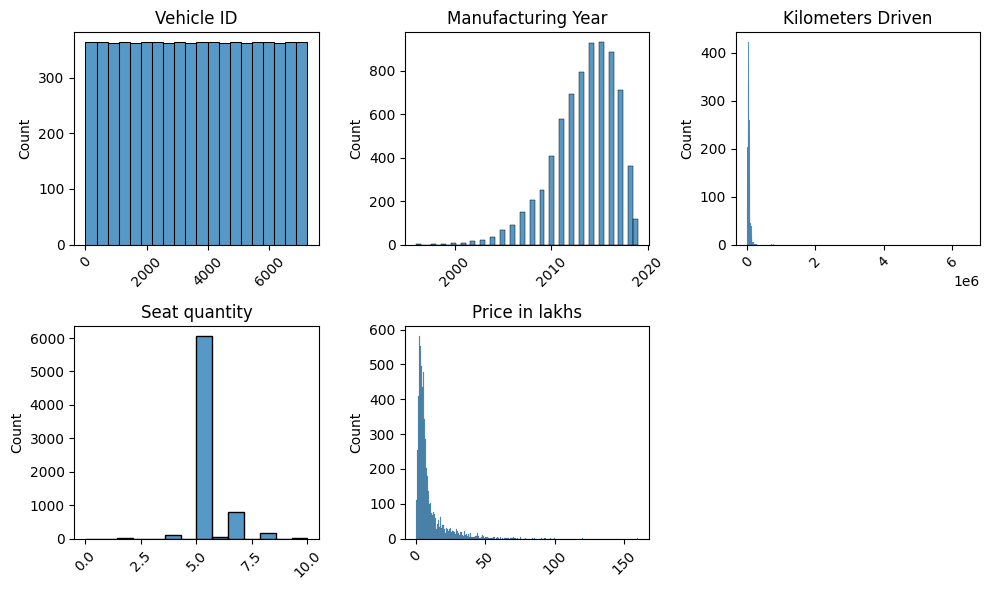

In [6]:
logger.debug("Plotting numeric data")
custom_labels = {
    'S.No.': {
        'title': 'Vehicle ID',
        'xlabel': ''
    },
    'Year': {
        'title': 'Manufacturing Year',
        'xlabel': ''
    },
    'Kilometers_Driven': {
        'title': 'Kilometers Driven',
        'xlabel': ''
    },
    'Seats': {
        'title': 'Seat quantity',
        'xlabel': ''
    },
    'Price': {
        'title': 'Price in lakhs',
        'xlabel': ''
    }
}
# Plot histograms for number columns
#cars_df_raw.select_dtypes(include='number').hist(bins=30 , figsize=(12, 8), layout=(3, 3), edgecolor='black', color='aquamarine')
number_columns = cars_df_raw.select_dtypes(include='number')

fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()  # Flatten to make indexing easier

for i, col in enumerate(number_columns.columns):
    sns.histplot(data=number_columns, x=col, ax=axes[i])
    axes[i].tick_params(axis='x',rotation=45)    
    axes[i].set_title(col)
    
    if col in custom_labels:
        axes[i].set_title(custom_labels[col]['title'])
        axes[i].set_xlabel(custom_labels[col]['xlabel'])
    else:
        axes[i].set_title(col)
        axes[i].set_xlabel(col)

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()    
plt.show()


Drop ID column because it has no value towards the exploration and later on for machine learning use.

In [7]:
cars_df = cars_df_raw.copy()
cars_df.drop('S.No.', axis=1, inplace=True)
logger.debug("Drop S.No. Column")

2025-06-13 23:29:54,279 | DEBUG | data_cleaning_ | Drop S.No. Column


# Check Null Values

We are going to use regex to convert any "null" string value. 

2025-06-13 23:29:54,375 | DEBUG | data_cleaning_ | S.No.                   0
Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 46
Power                  46
Seats                  53
New_Price            6247
Price                1234
dtype: int64
2025-06-13 23:29:54,378 | DEBUG | data_cleaning_ | Check dataset null values 7628


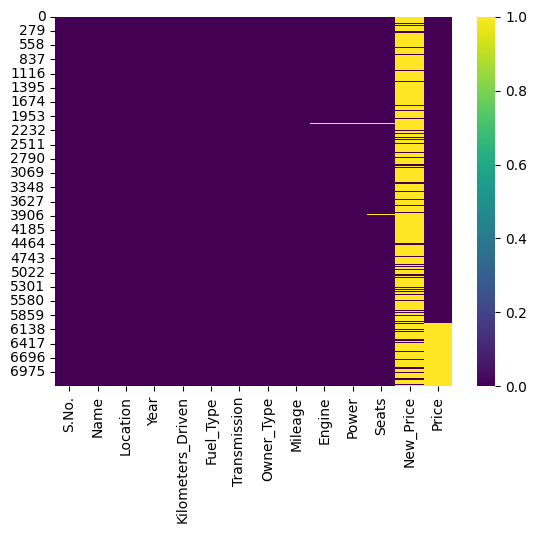

In [8]:
sns.heatmap(cars_df_raw.isnull(), cmap='viridis')
logger.debug(cars_df_raw.isnull().sum())
logger.debug(f"Check dataset null values {cars_df_raw.isnull().sum().sum()}")

2025-06-13 23:29:54,489 | DEBUG | data_cleaning_ | Using regex to find hidden null values to convert to actual nulls
2025-06-13 23:29:54,527 | DEBUG | data_cleaning_ | Raw Dataset:
Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 46
Power                  46
Seats                  53
New_Price            6247
Price                1234
dtype: int64

Using regex:
Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 46
Power                 175
Seats                  53
New_Price            6247
Price                1234
dtype: int64


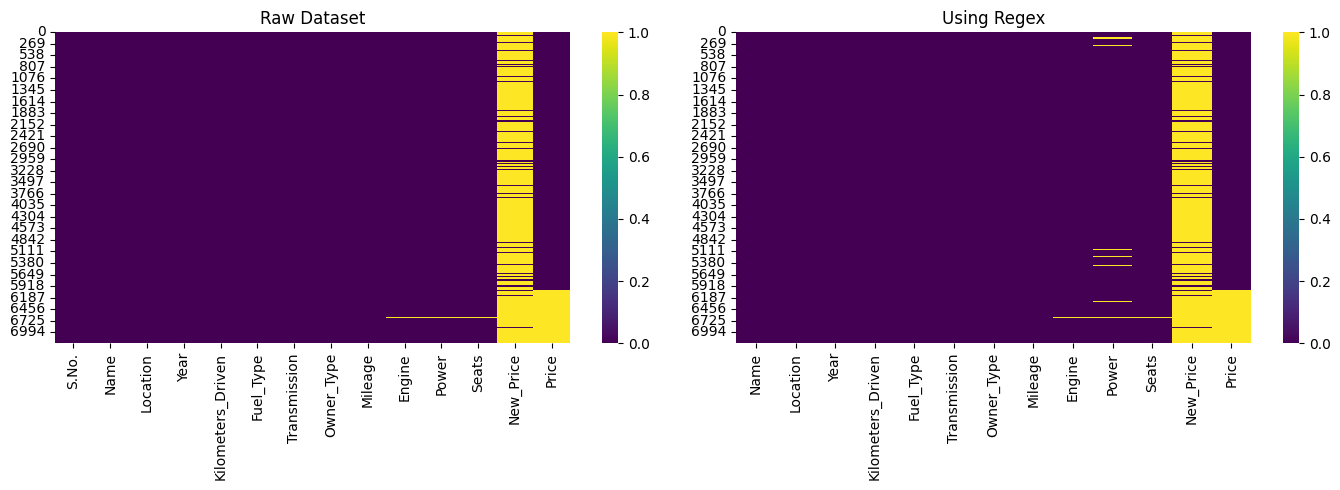

In [9]:
# Replace null values with NaN
# regex=r"(?i)^null.*"
# (?i) inline flag that treats uppercase and lowercase letters as equivalent. 
# ^ Asserts the start of the string
# null matches the literal sequence of characters 'null'
# .* matches any character (except for newline) zero or more times and the asterisk(*) means "zero or more times"
logger.debug(f"Using regex to find hidden null values to convert to actual nulls")
cars_df.replace(regex=r"(?i).*null.*", value=np.nan, inplace=True)
logger.debug(f"Raw Dataset:\n{cars_df_raw.drop(columns="S.No.").isnull().sum()}\n\nUsing regex:\n{cars_df.isnull().sum()}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap for raw dataframe
sns.heatmap(cars_df_raw.isnull(), cmap='viridis', ax=axes[0],)
axes[0].set_title("Raw Dataset")

# Heatmap for cleaned dataframe
sns.heatmap(cars_df.isnull(), cmap='viridis', ax=axes[1],)
axes[1].set_title("Using Regex")

plt.tight_layout()
plt.show()


In [10]:
# Check for duplicated rows in new_cars_df
duplicates = cars_df.duplicated()
print("Number of duplicate rows:", duplicates.sum())

# Remove duplicated rows
if duplicates.sum() > 0:   
    cars_df.drop_duplicates(inplace=True)
    print("New shape after duplicates removal:", cars_df.shape)

logger.debug(f"Deleting {duplicates.sum()} duplicated rows")

2025-06-13 23:29:54,907 | DEBUG | data_cleaning_ | Deleting 1 duplicated rows


Number of duplicate rows: 1
New shape after duplicates removal: (7252, 13)


## Prices

```
New_Price            6247
Price                1234
```
We can see that most of the missing data comes from the New_Price column since not all the vehicles have gotten a new price.
Eitherway since its supposed to be the new price we can extract those new prices, add/overwrite the data on the price column and get rid of the new_price column.

#### New_Price/Price | Cleaning and currency conversion 

Check unique suffixes on the New_Price column

In [11]:
# Check what UNIQUE suffixes are used in a specific column and count the quantity of each
# Returns a dictionary with the UNIQUE suffixes and quantity {'CC':233,'bhp': 123}

def count_suffix(dataframe, column):
    values = dataframe[column]
    unique_suffixes_count = {}
    for value in values:
        if isinstance(value, str):
            parts = value.split()
            if len(parts) > 1:
                suffix = parts[1]
                unique_suffixes_count[suffix] = unique_suffixes_count.get(suffix, 0) + 1
            else:
                unique_suffixes_count[value] = unique_suffixes_count.get(value, 0) + 1                
    return unique_suffixes_count

def get_unique_suffixes(dataframe, column):
    unique_values = dataframe[column].unique()  # Get only unique values
    suffixes_set = set()
    for value in unique_values:
        if isinstance(value, str):
            parts = value.split()
            if len(parts) > 1:
                suffixes_set.add(parts[1])  # Add the suffix to the set
            else:
                suffixes_set.add(value) # Add the value itself if no suffix is found
    return suffixes_set

Quantity of Lakh and Cr from the New_Price column

In [12]:
currency_dictionary = count_suffix(cars_df, 'New_Price')
for key, value in currency_dictionary.items():
    print(f"{key}: {value} values")
logger.debug("Checking suffixes on New_Price column")

2025-06-13 23:29:54,925 | DEBUG | data_cleaning_ | Checking suffixes on New_Price column


Lakh: 986 values
Cr: 20 values


- Remove the suffixes and transform CR into LAKHs. 
- Transforming LAKHs in to INR and convert INR to EURO into a new column Price_EUR

In [13]:
# 1 Lakh == 10^5 (100,000 INR)
# 1 Cr == 10^7 (10,000,000 INR)
# 1 EURO == 97.83 INR
EURO_TO_INR = 97.83
# Price conversion from INR Lakh to euros (LAKH*100000)/96.87 = euro 
#New_Price column contains LAKH and CR Currency
suffixes_dict = dict.fromkeys(get_unique_suffixes(cars_df, 'New_Price'),0)
# Transform 'New_Price' values and update the 'Price' column with the new prices
for index, value in cars_df['New_Price'].items():
    if isinstance(value, str) and value.endswith(tuple(suffixes_dict.keys())):
        price,suffix = value.split()
        price = float(price)        
        if suffix == 'Cr': #Cr | Convert Cr to Lakh
            price_in_lakh = price * 100
        else:
            # Price is in Lakh by default
            price_in_lakh = price           
        # Update the 'Price' column with the converted value
        cars_df.at[index, 'Price'] = price_in_lakh

# Transform 'Price' values to euros in a new column 'price_euro' and round them up to 2 decimal places
# Currency conversion from INR to EURO
cars_df['price_euro'] = ((cars_df['Price']*100000)/EURO_TO_INR).round(2)
logger.debug("Moving prices from 'New_Price' to 'Price' column and creating a new price_euro column with prices converted from lakh to euro" )

2025-06-13 23:29:54,943 | DEBUG | data_cleaning_ | Moving prices from 'New_Price' to 'Price' column and creating a new price_euro column with prices converted from lakh to euro


In [14]:
print(cars_df.isnull().sum())
logger.debug(f"Null value count {cars_df.isnull().sum().sum()-cars_df["price_euro"].isnull().sum()}")

2025-06-13 23:29:54,953 | DEBUG | data_cleaning_ | Null value count 7573


Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 46
Power                 175
Seats                  53
New_Price            6246
Price                1051
price_euro           1051
dtype: int64


2025-06-13 23:29:54,958 | DEBUG | data_cleaning_ | Plot differences between raw and cleaned dataset + remove 'New_Price' column


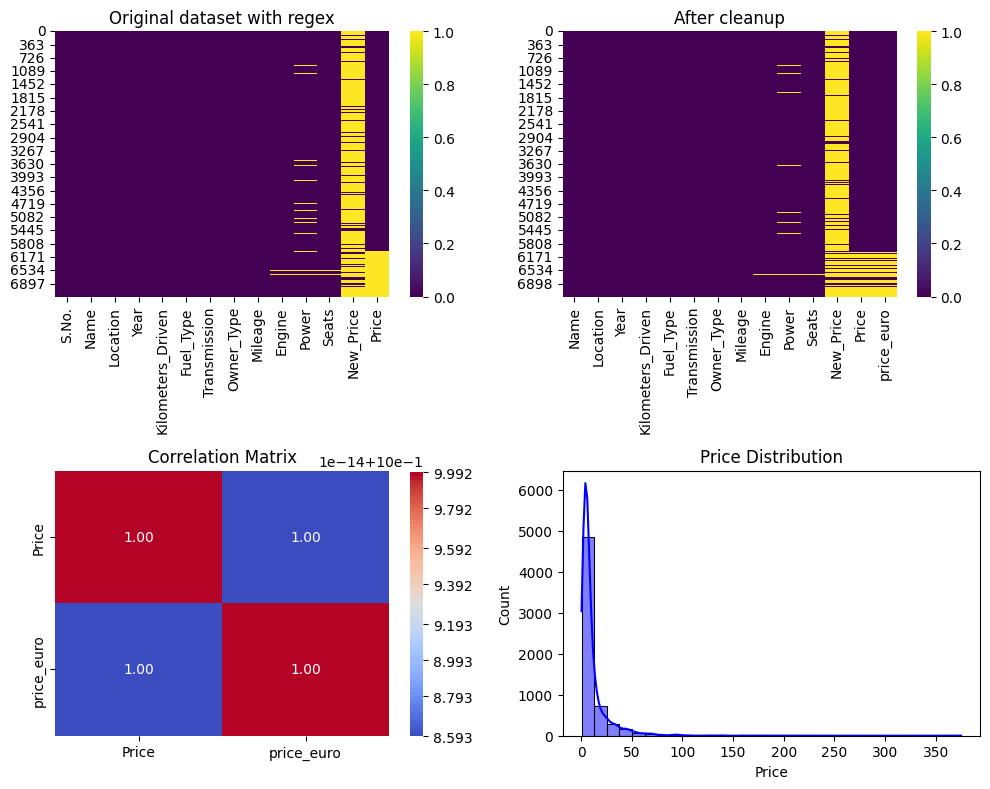

2025-06-13 23:29:55,588 | DEBUG | data_cleaning_ | Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 46
Power                 175
Seats                  53
New_Price            6246
Price                1051
price_euro           1051
dtype: int64


In [15]:
logger.debug("Plot differences between raw and cleaned dataset + remove 'New_Price' column" )
#Drop the 'New_Price' column as it is no longer needed
df_after_regex = cars_df_raw.copy()
df_after_regex.replace(regex=r"(?i).*null.*", value=np.nan, inplace=True)


fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()
cols = ["Price","price_euro"]
subset = cars_df[cols]
corr_matrix = subset.corr()
sns.heatmap(df_after_regex.isnull(), cmap='viridis',ax=axes[0])
sns.heatmap(cars_df.isnull(), cmap='viridis',ax=axes[1])
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", ax=axes[2])
sns.histplot(cars_df['Price'], ax=axes[3], color='blue', kde=True, bins=30)
axes[0].set_title("Original dataset with regex")
axes[1].set_title("After cleanup")
axes[2].set_title("Correlation Matrix")
axes[3].set_title("Price Distribution")
plt.tight_layout()
plt.show()

logger.debug(cars_df.isnull().sum())
new_cars_df = cars_df.drop(['New_Price'],axis=1)


## Price Summary 
We have removed the suffixes from new_price, transformed the different indian numeric (Lakh|Cr) systems into LAKHs for price column. 

Dropped the new_price column and converted the prices from the price column from INR to EURO in a new column price_euro.

### Deleting Null values
After treating the columns with most null values we can get rid of the rest since don't have enough information. 

In [16]:
logger.debug(f"Shape before dropping all null values {new_cars_df.shape}")
new_cars_df_copy = new_cars_df.copy()
# Drop all missing values 
new_cars_df.dropna(inplace=True)
logger.debug(new_cars_df.isnull().sum())
logger.debug(f"Shape after dropping all null values {new_cars_df.shape}. Total values removed: {new_cars_df_copy.shape[0]-new_cars_df.shape[0]}")

2025-06-13 23:29:55,594 | DEBUG | data_cleaning_ | Shape before dropping all null values (7252, 13)
2025-06-13 23:29:55,599 | DEBUG | data_cleaning_ | Name                 0
Location             0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
Price                0
price_euro           0
dtype: int64
2025-06-13 23:29:55,600 | DEBUG | data_cleaning_ | Shape after dropping all null values (6054, 13). Total values removed: 1198


## Mileage
We can see there are two types of mileage being inputed **km/kg** and **kmpl**. There are also few types of fuel which after doing some research, and finding out that CNG and LPG are a really small amount compared to Diesel an petrol, that means kmpl is the most used unit of measurement. We'll convert the km/kg to kmpl and we'll convert all the row into float by removing the suffixes

#### (CNG) Compressed Natural Gas 
##### According to [Bigas website](https://www.bigas.it/en/faq-en/292-faq-fuel-distance) 1kg of CNG corresponds aproximetly 1.7 liters, so dividing by 1.7 or multiplying by 0.588 = (1/1.7) we can obtain the kmpl
#### (LPG) Liquified Petroleum Gas 
##### According to [convert-kg-to-liters-lpg](https://conversion.website.yandexcloud.net/convert-kg-to-liters-lpg.html) website, 1kg occupies roughly 1.8 liters, so dividing 1.8 or multiplying by aproximately 0.55 = (1 / 1.8) we can obtain the kmpl


In [17]:
# Check suffixes for each type of fuel
fuel_suffixes = {}
for fuel_type in new_cars_df['Fuel_Type'].unique():
    if isinstance(fuel_type, str):  # Ensure the fuel type is a string
        # Filter rows for the current fuel type
        filtered_df = new_cars_df[new_cars_df['Fuel_Type'] == fuel_type]
        # Get unique suffixes from the 'Mileage' column
        suffixes = get_unique_suffixes(filtered_df, 'Mileage')
        fuel_suffixes[fuel_type] = suffixes
fuel_types = count_suffix(new_cars_df, 'Fuel_Type')
logger.debug(f'Quantity of fuel rows per type:{fuel_types}\n')
# Print the suffixes for each fuel type
logger.debug('Mileage suffixes for each fuel type:')
fuels = {}
for fuel, suffixes in fuel_suffixes.items():
    fuels[fuel] = suffixes
    print(f"Fuel Type: {fuel} | Suffixes: {suffixes}")
logger.debug(f"Checking fuel types per row: {fuel_types}. Suffixes per fuel: {fuels}")

2025-06-13 23:29:55,611 | DEBUG | data_cleaning_ | Quantity of fuel rows per type:{'CNG': 56, 'Diesel': 3248, 'Petrol': 2740, 'LPG': 10}

2025-06-13 23:29:55,611 | DEBUG | data_cleaning_ | Mileage suffixes for each fuel type:
2025-06-13 23:29:55,612 | DEBUG | data_cleaning_ | Checking fuel types per row: {'CNG': 56, 'Diesel': 3248, 'Petrol': 2740, 'LPG': 10}. Suffixes per fuel: {'CNG': {'km/kg'}, 'Diesel': {'kmpl'}, 'Petrol': {'kmpl'}, 'LPG': {'km/kg'}}


Fuel Type: CNG | Suffixes: {'km/kg'}
Fuel Type: Diesel | Suffixes: {'kmpl'}
Fuel Type: Petrol | Suffixes: {'kmpl'}
Fuel Type: LPG | Suffixes: {'km/kg'}


In [18]:
def convert_to_kmpl(value,mileage):
    CNG_TO_KMPL = 0.588
    LPG_TO_KMPL = 0.55
    float_mileage = float(mileage)
    if value == 'CNG':
        conversion_result = float_mileage * CNG_TO_KMPL
    if value == 'LPG':
        conversion_result = float_mileage * LPG_TO_KMPL
    return round(conversion_result,2)


fuel_to_convert = ('CNG','LPG')
for index, value in new_cars_df['Fuel_Type'].items():
    if isinstance(value,str):
        mileage_value = new_cars_df.at[index,'Mileage'] 
        mileage = mileage_value.split()[0]
        if value in fuel_to_convert:            
            if isinstance(mileage_value,str) and mileage_value.endswith('km/kg'):                
                new_cars_df.at[index,'Mileage'] = convert_to_kmpl(value,mileage)
        else:
            if isinstance(mileage_value,str) and mileage_value.endswith('kmpl'):
                new_cars_df.at[index,'Mileage'] = mileage_value.split()[0]

# Convert 'Mileage' column to float column
new_cars_df['Mileage'] = new_cars_df['Mileage'].astype(float)
new_cars_df['Mileage'].describe()


count    6054.000000
mean       18.210927
std         4.300629
min         0.000000
25%        15.260000
50%        18.200000
75%        21.100000
max        28.400000
Name: Mileage, dtype: float64

After cleaning the mileage column we can see that there is at least one row with a 0 value. Since we cannot get the actual value we'll get rid those.

2025-06-13 23:29:55,722 | DEBUG | data_cleaning_ | Dataset shape before removing null value kmpl: (6054, 13)
2025-06-13 23:29:55,725 | DEBUG | data_cleaning_ | Dataset shape after removing null value kmpl: (6026, 13)
2025-06-13 23:29:55,726 | DEBUG | data_cleaning_ | Removed rows from Mileage column for 0 value: 28


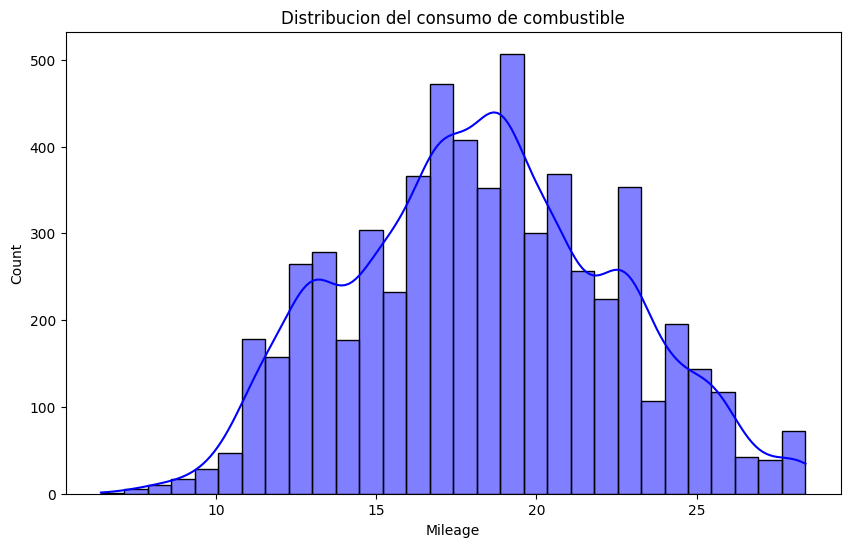

count    6026.000000
mean       18.295544
std         4.127103
min         6.400000
25%        15.290000
50%        18.250000
75%        21.100000
max        28.400000
Name: Mileage, dtype: float64

In [19]:
shape_before = new_cars_df.shape
logger.debug(f'Dataset shape before removing null value kmpl: {new_cars_df.shape}')
new_cars_df = new_cars_df[new_cars_df['Mileage'] > 0].reset_index(drop=True)
logger.debug(f'Dataset shape after removing null value kmpl: {new_cars_df.shape}')
logger.debug(f"Removed rows from Mileage column for 0 value: {shape_before[0] - new_cars_df.shape[0]}")

plt.figure(figsize=(10, 6))
sns.histplot(new_cars_df['Mileage'], color='blue', kde=True, bins=30)
plt.title('Distribucion del consumo de combustible')
plt.show()
new_cars_df['Mileage'].describe()

### Power / Engine

We can see on that both only have one suffix so we are goin to get rid of it and change the data type of each column.

- Engine to int
- Power to float

In [20]:
logger.debug(count_suffix(new_cars_df, 'Power'))
logger.debug(count_suffix(new_cars_df, 'Engine'))

2025-06-13 23:29:55,837 | DEBUG | data_cleaning_ | {'bhp': 6026}
2025-06-13 23:29:55,839 | DEBUG | data_cleaning_ | {'CC': 6026}


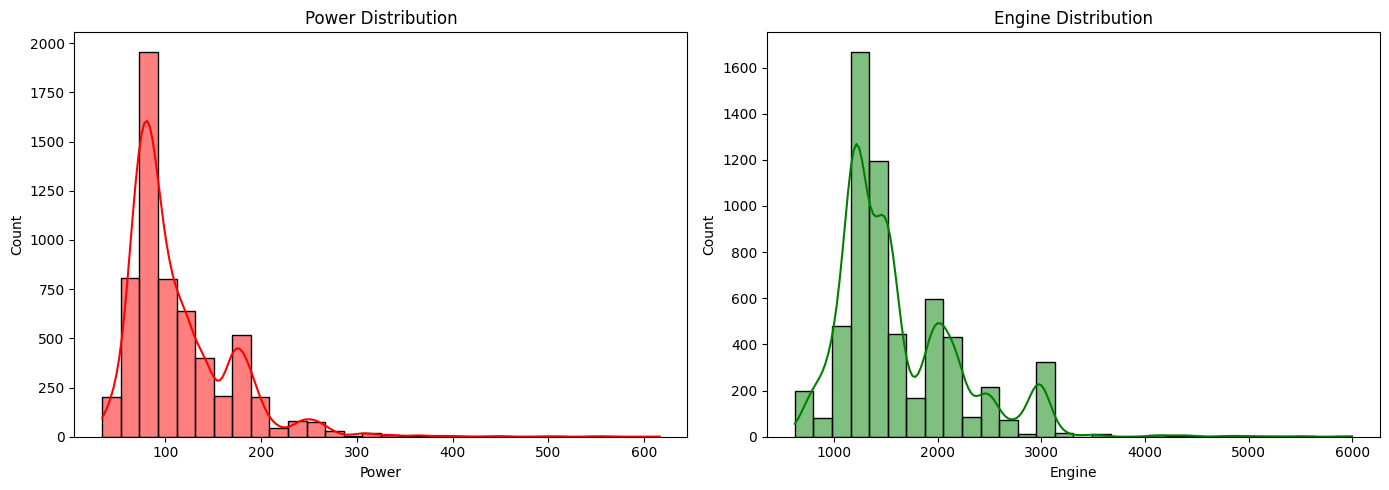

,Power,Engine
count,6026.000000,6026.000000
mean,113.198960,1621.415367
std,54.107103,599.181000
min,34.200000,624.000000
25%,75.000000,1198.000000
50%,94.000000,1495.000000
75%,138.100000,1984.000000
max,616.000000,5998.000000


In [21]:
def remove_suffix(value):
    if isinstance(value, str):
        parts = value.split()
        if len(parts) > 1:  # Check if there is a suffix to remove
            return parts[0]  # Return the numeric part
        return value  # Return the value as is if no suffix is found
    return value

# Remove suffixes from 'Engine' and 'Power' columns
new_cars_df['Engine'] = new_cars_df['Engine'].map(remove_suffix).fillna(0).astype(int)
new_cars_df['Power'] = new_cars_df['Power'].map(remove_suffix).fillna(0).astype(float)

figure, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(new_cars_df['Power'], ax=axes[0], color='red', kde=True, bins=30)
sns.histplot(new_cars_df['Engine'], ax=axes[1], color='green', kde=True, bins=30)
axes[0].set_title("Power Distribution")
axes[1].set_title("Engine Distribution")
plt.tight_layout()
plt.show()
new_cars_df[['Power','Engine']].describe()

### Seats
We'll just change the  from float to int

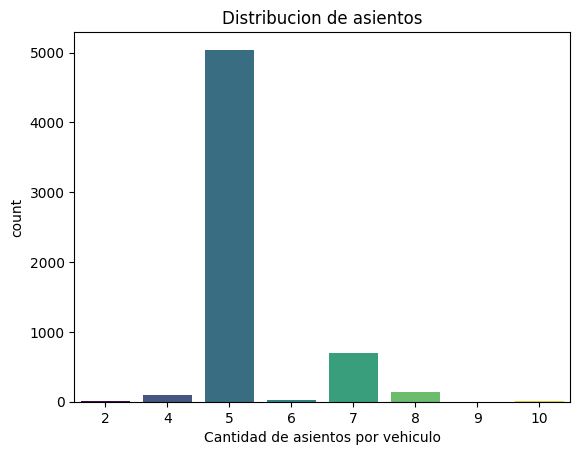

In [22]:
new_cars_df['Seats'].unique()
new_cars_df['Seats'] = new_cars_df['Seats'].astype(int)

plt.Figure(figsize=(10, 6))
sns.countplot(data=new_cars_df, x='Seats', palette='viridis', hue='Seats', legend=False)
plt.title('Distribucion de asientos')
plt.xlabel('Cantidad de asientos por vehiculo')
plt.show()

### Year
We'll modify it to instead of showing the year, it shows the age of the car

In [23]:
current_year = datetime.datetime.today().year
manufacturing_year = new_cars_df['Year'].copy()  # Store original manufacturing years
# Calculate age without lambda - direct vectorized operation
new_cars_df['Year'] = current_year - new_cars_df['Year']

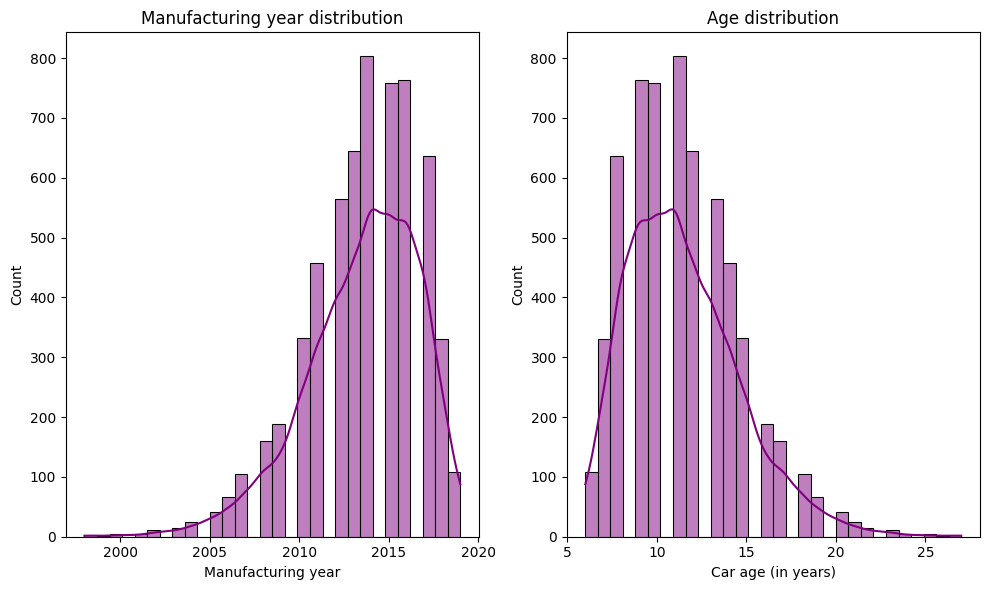

In [24]:

# Create the plots
figure, axes = plt.subplots(1, 2, figsize=(10, 6))

# Plot manufacturing year distribution
sns.histplot(manufacturing_year, color='purple', kde=True, bins=30, ax=axes[0])
axes[0].set_title('Manufacturing year distribution')
axes[0].set_xlabel('Manufacturing year')

# Plot vehicle age distribution
sns.histplot(new_cars_df['Year'], color='purple', kde=True, bins=30, ax=axes[1])
axes[1].set_title('Age distribution')
axes[1].set_xlabel('Car age (in years)')

plt.tight_layout()
plt.show()

### Owner number
We'll transform it from string to int and since we really don't have information about that fourth & above we'll keep it at 4 


2025-06-13 23:29:56,371 | DEBUG | data_cleaning_ | Mapping Owner_Type values


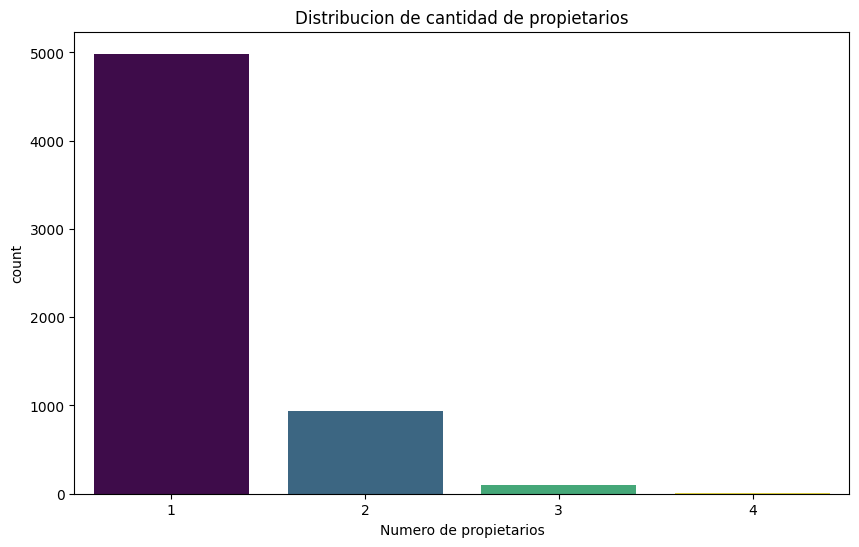

In [25]:
logger.debug(f"Mapping Owner_Type values")
new_cars_df['Owner_Type'] = new_cars_df['Owner_Type'].map({'First':1,'Second':2,'Third':3,'Fourth & Above':4}).fillna(0).astype(int)
new_cars_df['Owner_Type'].describe()

plt.figure(figsize=(10, 6))
sns.countplot(data=new_cars_df, x='Owner_Type', palette='viridis', hue='Owner_Type', legend=False)
plt.title('Distribucion de cantidad de propietarios')
plt.xlabel('Numero de propietarios')
plt.show()

## Rename the columns


In [26]:
logger.debug(f"Renaming columns")
new_cars_df.rename(columns={'S.No.':'id','Name':'name','Location':'location','Year':'car_age','Kilometers_Driven':'kilometers_driven','Fuel_Type':'fuel_type','Transmission':'transmission','Owner_Type':'owner_number','Mileage':'mileage_kmpl','Engine':'engine_cc','Power':'power_bhp','Seats':'seats','Price':'price_lakh'},inplace=True)

2025-06-13 23:29:56,443 | DEBUG | data_cleaning_ | Renaming columns


# Dataset After cleaning

In [27]:
new_cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6026 entries, 0 to 6025
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               6026 non-null   object 
 1   location           6026 non-null   object 
 2   car_age            6026 non-null   int64  
 3   kilometers_driven  6026 non-null   int64  
 4   fuel_type          6026 non-null   object 
 5   transmission       6026 non-null   object 
 6   owner_number       6026 non-null   int64  
 7   mileage_kmpl       6026 non-null   float64
 8   engine_cc          6026 non-null   int64  
 9   power_bhp          6026 non-null   float64
 10  seats              6026 non-null   int64  
 11  price_lakh         6026 non-null   float64
 12  price_euro         6026 non-null   float64
dtypes: float64(4), int64(5), object(4)
memory usage: 612.1+ KB


In [28]:
new_cars_df.describe()

,car_age,kilometers_driven,owner_number,mileage_kmpl,engine_cc,power_bhp,seats,price_lakh,price_euro
count,6026.000000,6.026000e+03,6026.000000,6026.000000,6026.000000,6026.000000,6026.000000,6026.000000,6026.000000
mean,11.444739,5.773634e+04,1.191835,18.295544,1621.415367,113.198960,5.284600,11.185518,11433.627506
std,3.166057,9.113054e+04,0.442220,4.127103,599.181000,54.107103,0.806294,15.603125,15949.223530
min,6.000000,1.710000e+02,1.000000,6.400000,624.000000,34.200000,2.000000,0.440000,449.760000
25%,9.000000,3.282675e+04,1.000000,15.290000,1198.000000,75.000000,5.000000,3.750000,3833.180000
50%,11.000000,5.200000e+04,1.000000,18.250000,1495.000000,94.000000,5.000000,6.105000,6240.420000
75%,13.000000,7.200000e+04,1.000000,21.100000,1984.000000,138.100000,5.000000,11.500000,11755.090000
max,27.000000,6.500000e+06,4.000000,28.400000,5998.000000,616.000000,10.000000,375.000000,383318.000000


In [29]:
new_cars_df.to_csv(dataset_save_path, index=False)
logger.debug(f"Saving dataset to {dataset_save_path}")
logger.debug(f"Finalizing data exploration.")

2025-06-13 23:29:56,509 | DEBUG | data_cleaning_ | Saving dataset to datasets/vehicles/clean_car_df.csv
2025-06-13 23:29:56,509 | DEBUG | data_cleaning_ | Finalizing data exploration.


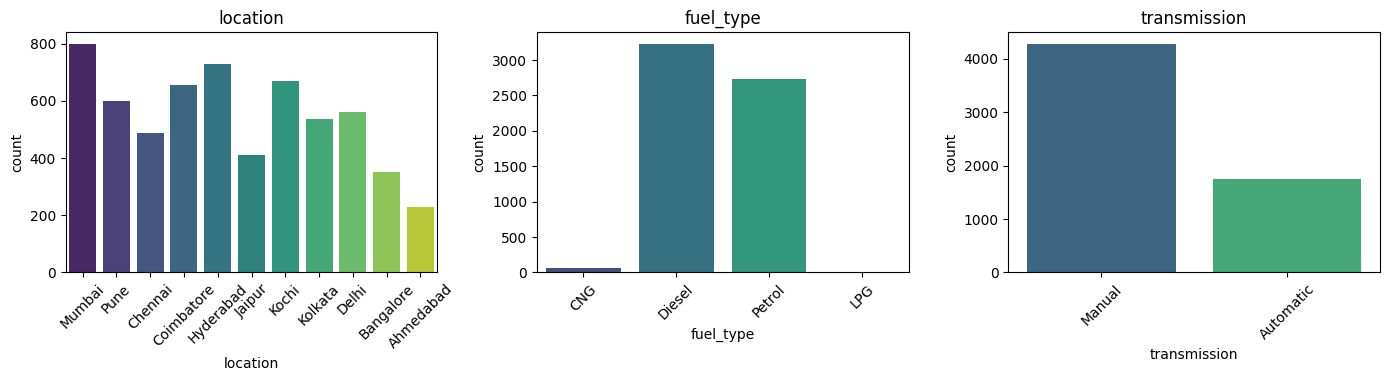

In [30]:
cat_columns = new_cars_df.select_dtypes(include=['object']).drop('name', axis=1)

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(14, 10))
axes = axes.flatten()  # Flatten to make indexing easier

# Plot each categorical column
for i, col in enumerate(cat_columns.columns):
    sns.countplot(data=cat_columns, x=col, ax=axes[i],palette='viridis',hue=col, legend=False)
    axes[i].tick_params(axis='x',rotation=45)    
    axes[i].set_title(col)

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

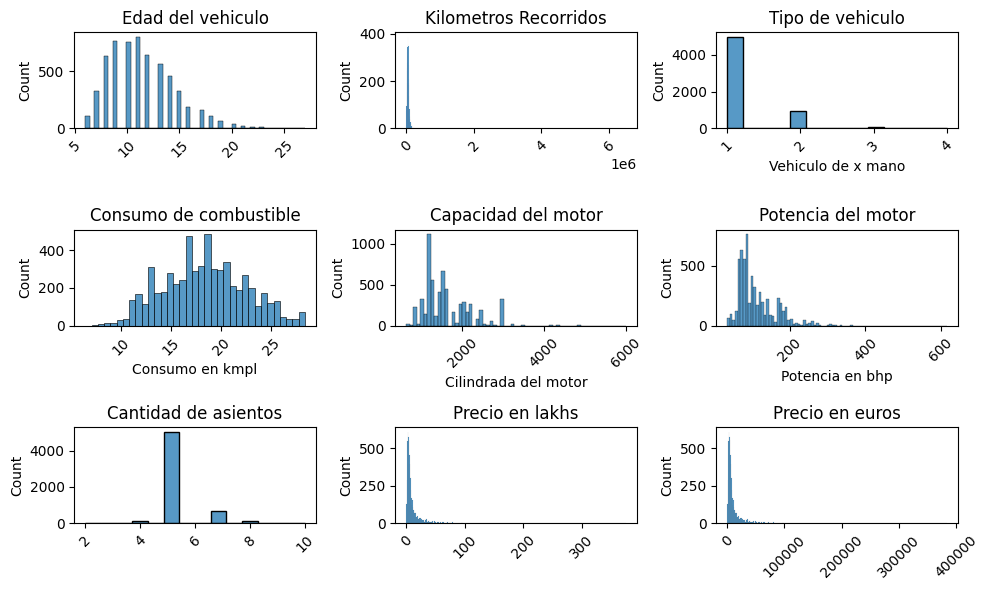

In [31]:
custom_labels = {
    'car_age': {
        'title': 'Edad del vehiculo',
        'xlabel': ''
    },
    'kilometers_driven': {
        'title': 'Kilometros Recorridos',
        'xlabel': ''
    },
    'owner_number': {
        'title': 'Tipo de vehiculo',
        'xlabel': 'Vehiculo de x mano'
    },
    'mileage_kmpl': {
        'title': 'Consumo de combustible',
        'xlabel': 'Consumo en kmpl'
    },
    'engine_cc': {
        'title': 'Capacidad del motor',
        'xlabel': 'Cilindrada del motor'
    },
    'power_bhp': {
        'title': 'Potencia del motor',
        'xlabel': 'Potencia en bhp'
    },
    'seats': {
        'title': 'Cantidad de asientos',
        'xlabel': ''
    },
    'price_lakh': {
        'title': 'Precio en lakhs',
        'xlabel': ''
    },
    'price_euro': {
        'title': 'Precio en euros',
        'xlabel': ''
    }
}
# Plot histograms for number columns
#cars_df_raw.select_dtypes(include='number').hist(bins=30 , figsize=(12, 8), layout=(3, 3), edgecolor='black', color='aquamarine')
number_columns = new_cars_df.select_dtypes(include='number')

fig, axes = plt.subplots(3, 3, figsize=(10, 6))
axes = axes.flatten()  # Flatten to make indexing easier

for i, col in enumerate(number_columns.columns):
    sns.histplot(data=number_columns, x=col, ax=axes[i])
    axes[i].tick_params(axis='x',rotation=45)    
    axes[i].set_title(col)
    
    if col in custom_labels:
        axes[i].set_title(custom_labels[col]['title'])
        axes[i].set_xlabel(custom_labels[col]['xlabel'])
    else:
        axes[i].set_title(col)
        axes[i].set_xlabel(col)

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()    
plt.show()